### Google Drive'a bağlanma

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import os 
os.chdir('/gdrive/My Drive/Duygu Tanıma')

In [3]:
!ls

'Adsız klasör'	 Duygu_tanima.ipynb   Duygu_Tanıma.ipynb   fer2013.csv	 images


### Kütüphanelerin Yüklenmesi

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 

import keras 
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils 
from keras.preprocessing import image 
from keras.callbacks import ModelCheckpoint

### Veri Setinin Okunması
* Bize verilen dataset 35887 satır ve 3 sütundan oluşuyor.

* Veriden Bir Kısım Görelim!

In [5]:
path =  '/gdrive/My Drive/Duygu Tanıma/'

data = pd.read_csv(path + 'fer2013.csv')
data.shape

(35887, 3)

* Veri Setinin ilk kısmını görelim.

In [6]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


* Train ve Test performansının ölçüldüğü veri sayılarını inceliyelim

In [7]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

### Eğitim Verisi için ön işleme adımları

In [8]:
np.unique(data['Usage'].values.ravel())

print('Eğitim Setindeki Örnek Sayısı: %d'%(len(data[data.Usage == 'Training'])))

Eğitim Setindeki Örnek Sayısı: 28709


* Eğitim işlemi için veri Kümesinde ayrılmış olan **Training** kısmını alma

In [9]:
train_data = data [data.Usage == 'Training']

* Eğitim örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse edip, liste olarak değişkene almamız gerekiyor.

In [10]:
train_pixels = train_data.pixels.str.split(" ").tolist()

train_pixels = pd.DataFrame(train_pixels, dtype=int)
train_images = train_pixels.values 
train_images = train_images.astype(np.float)

print(train_images)

print(train_images.shape)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


<ipython-input-10-9d85d8430ae6>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_images = train_images.astype(np.float)


* Görüntüyü 48x48 piksel şeklinde göstermek için fonksiyon tanımlayalım.

In [11]:
def show(img):
    show_image = img.reshape(48, 48)

    plt.axis('off')
    plt.imshow(show_image, cmap='gray')

* Show Fonksiyonunu Eğitim kümesinden bir görselin üzerinde Kullanalım.

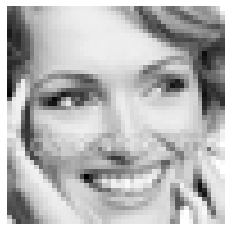

In [12]:
show(train_images[28687])

* Eğitim kümesinde Kaç Sınıf Bulunuyor ( Duygu Sayısı )

In [13]:
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print("Farklı yüz ifadelerinin Sayısı: %d"%train_labels_count)

Farklı yüz ifadelerinin Sayısı: 7


### One Hot ile eğitim kümesindeki verilerin her birine düşen sınıfı yani işlemin boyutunu görelim.

In [14]:
def dense_to_one_hot(labels_dense, num_classes):
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot

In [15]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)

y_train = y_train.astype(np.uint8)

print(y_train.shape)

(28709, 7)


### Test Verisi ön işleme adımları

In [16]:
np.unique(data["Usage"].values.ravel())

print("Test setindeki örnek sayısı: %d"%(len(data[data.Usage == "PublicTest"])))

Test setindeki örnek sayısı: 3589


### Eğitim işlemi için veri kümesinde ayrılmış olan **PublicTest** kısmını alıyoruz

In [17]:
test_data = data[data.Usage == "PublicTest"]
test_pixels = test_data.pixels.str.split(" ").tolist()

test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values 
test_images = test_images.astype(np.float)

print(test_images.shape)

<ipython-input-17-a2cd45c83ae4>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_images = test_images.astype(np.float)


(3589, 2304)


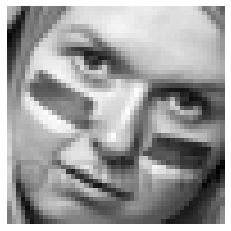

In [18]:
show(test_images[1001])

### One hot ile Test Kümesindeki verilerin her birine düşen sınıfı yani eğitim işlemi boyutunu görelim

In [19]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)

y_test = y_test.astype(np.uint8)

print(y_test.shape)

(3589, 7)


### Test Kümesinden örnek görüntüler

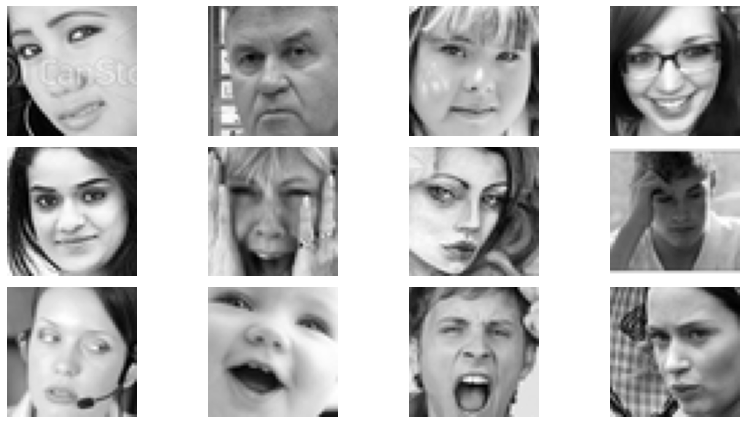

In [20]:
plt.figure(0, figsize=(12,6))
for i in range(1,13):
  plt.subplot(3, 4, i)
  plt.axis('off')

  image=test_images[i].reshape(48,48)
  plt.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

### Derin Evrişimli Sinir Ağı Modeli

In [21]:
model = Sequential()
# 1. Katman

model.add(Conv2D(64, 3, data_format='channels_last', kernel_initializer="he_normal", input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

#2. Katman

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
  # %60 unutma Dropout işlemi (Nöron silme)
model.add(Dropout(0.6))


#3. Katman

model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation('relu'))


#4. Katman

model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation('relu'))


#5. Katman

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
  # %60 unutma Dropout işlemi (Nöron silme)
model.add(Dropout(0.6))
 
#6. Katman

model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation('relu'))


### Tam Bağlantı Katmanı
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
  # %60 unutma Dropout işlemi (Nöron silme)
model.add(Dropout(0.6))


### Çıkış Katmanı


model.add(Dense(7, activation='softmax'))

# optimizasyon ve başarım hesaplama metriklerinin belirlenmesi
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)        0

### Eğitim ve Test kümelerinin eleman sayısı, yükseklik ve genişlik, Kanal sayısı billgilerini ekrana yazalım.

In [22]:
X_train = train_images.reshape(-1, 48, 48, 1)
X_test = test_images.reshape(-1, 48, 48, 1)

print('Train: ', X_train.shape)
print("Test: ", X_test.shape)

Train:  (28709, 48, 48, 1)
Test:  (3589, 48, 48, 1)


### Eğitim ve Test Kümelerinin Duygu sınıfı sayısı.

In [23]:
print("Train: ", y_train.shape)
print("Test: ", y_test.shape)

Train:  (28709, 7)
Test:  (3589, 7)


### Eğitim işleminin gerçekleşmesini istediğimiz epoch, batchsize gibi değerlerin belirlenmesi  ve eğitim sonucunda ağırlıkların .h5 dosyası olarak Kaydedilmesi işlemleri

In [25]:
# En başarılı ağırlıkları Kaydet
checkpointer = ModelCheckpoint(filepath=path + 'face_model.h5', verbose=1, save_best_only=True)

epochs = 30
batchSize = 100

# modeli Çalıştır

hist = model.fit(X_train, y_train,
                 epochs = epochs,
                 shuffle=True,  # Resimler Karışık verilir.
                 batch_size = batchSize,
                 validation_data = (X_test, y_test),
                 callbacks = [checkpointer], verbose=2) # callback checkpointerımızı alacak

# save model to json (Eğitim yapmadan Tahmin (Prediction) için kullanabilellim diye)

model_json = model.to_json()
with open(path + 'face_model.json', 'w') as json_file:
  json_file.write(model_json)

Epoch 1/30

Epoch 1: val_loss improved from inf to 1.33164, saving model to /gdrive/My Drive/Duygu Tanıma/face_model.h5
288/288 - 9s - loss: 1.2686 - accuracy: 0.5136 - val_loss: 1.3316 - val_accuracy: 0.4909 - 9s/epoch - 30ms/step
Epoch 2/30

Epoch 2: val_loss improved from 1.33164 to 1.21518, saving model to /gdrive/My Drive/Duygu Tanıma/face_model.h5
288/288 - 8s - loss: 1.2438 - accuracy: 0.5269 - val_loss: 1.2152 - val_accuracy: 0.5222 - 8s/epoch - 28ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.21518 to 1.18795, saving model to /gdrive/My Drive/Duygu Tanıma/face_model.h5
288/288 - 8s - loss: 1.2316 - accuracy: 0.5313 - val_loss: 1.1880 - val_accuracy: 0.5408 - 8s/epoch - 28ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.18795 to 1.18142, saving model to /gdrive/My Drive/Duygu Tanıma/face_model.h5
288/288 - 8s - loss: 1.2188 - accuracy: 0.5374 - val_loss: 1.1814 - val_accuracy: 0.5542 - 8s/epoch - 28ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.18142 to 1.164

### Eğitim Sonucu elde edilen Eğitim ve Geçerleme (Validation) Sonuçlarının grafiksel olarak ifade edilip ekrana yazdırılması işlemleri

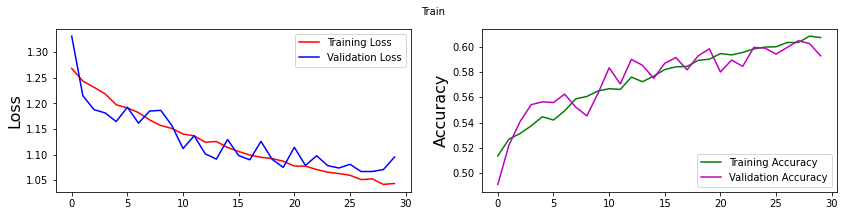

In [26]:
plt.figure(figsize=(14,3))

plt.subplot(1, 2, 1)
plt.suptitle('Train', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color='b', label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

### Kaggle submit edecek gibi PrivateTest ile Test edelim

In [27]:
test = data[['emotion', 'pixels']][data["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=" "))

test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [28]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [29]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [30]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerindeki doğruluk durumu: ",score)

PrivateTest üzerindeki doğruluk durumu:  [1.060116171836853, 0.5954304933547974]


### Farklı görüntülerle test işlemlerini yapıp sonuçları görselleştirellim.

In [31]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

In [39]:
from tensorflow.keras.preprocessing import image

In [32]:
# En iyi ağırlıkları yükle
model_best = load_model(path + 'face_model.h5')


In [33]:
os.chdir('/gdrive/My Drive/Duygu Tanıma/images')

In [34]:
!ls

brando.png  hababam.jpg        javierbardem.jpg  robertdeniro.jpg
emojis	    javierbardem2.jpg  kemal_sunal2.jpg


In [40]:
# test_image = x_test_private[60]

image_path = path + 'images/javierbardem.jpg'

# orjinal renkli görüntü
test_image_original = image.load_img(image_path) 

test_image = image.load_img(image_path, target_size=(48, 48), grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1)
results 

/usr/local/lib/python3.8/dist-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


1/1 [==============================] - 0s 276ms/step


array([[1.1257294e-01, 1.0053703e-04, 7.6968707e-02, 5.2292265e-02,
        2.7160043e-01, 2.2921478e-03, 4.8417300e-01]], dtype=float32)

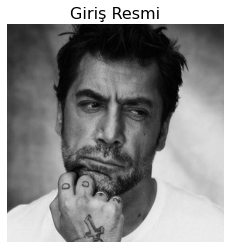

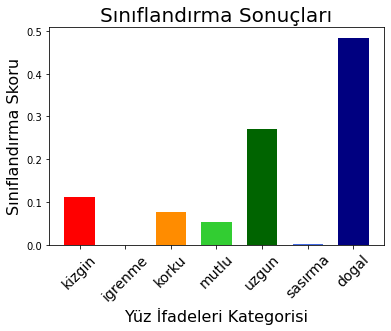

Sınıflandırma sonucu en yüksek oranla:  dogal


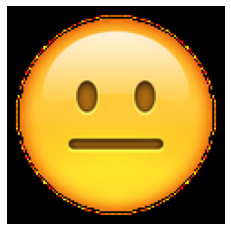

In [42]:
# Sınıflarımız 7 adet duygu durumumuz
class_names = ['kizgin', 'igrenme', 'korku', 'mutlu', 'uzgun', 'sasırma', 'dogal']

ind = 0.1+0.6*np.arange(len(class_names))
width = 0.4 # bar genişliği

color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']

# test resimlerini çizdirelim

plt.imshow(test_image_original)
plt.title('Giriş Resmi', fontsize=16)
plt.axis('off')
plt.show()

# sonuçlarımızı renklendirelim

for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i], width, color=color_list[i])

plt.title("Sınıflandırma Sonuçları", fontsize=20)
plt.xlabel('Yüz İfadeleri Kategorisi', fontsize=16)
plt.ylabel('Sınıflandırma Skoru', fontsize=16)
plt.xticks(ind, class_names, rotation=45, fontsize=14)
plt.show()

print("Sınıflandırma sonucu en yüksek oranla: ", class_names[np.argmax(results)])

# En yüksek skorlu duyguya karşılık emoji çizdirelim

emojis_img = image.load_img(path + 'images/emojis/%s.png'% str(class_names[np.argmax(results)]))

plt.imshow(emojis_img)
plt.axis('off')
plt.show()